In [1]:
import tellurium as te
import pandas as pd
import matplotlib
matplotlib.rcParams['text.usetex'] = False
import matplotlib.pyplot as plt


import os
import csv
import model_data
import fit_data
import tools
import simulate
import numpy as np
%matplotlib inline 

In [2]:
def get_paras_dic(modeltxt):
    dic={}
    model_file=open(modeltxt,'rb')
    print(model_file)
    for line in model_file:
        linespl = line.split()
        
        if (len(linespl)>=5):
            if (linespl[1] == '=') & ~(str(linespl[0]).startswith('//')) & ~(str(linespl[0]).endswith("'")):
                dic[linespl[0]] = linespl[2][0:-1] + ' ' +  linespl[4]  
    return dic

In [3]:
def simulate_model_for_parameter_values(parameter_values,
                                                   model,
                                           parameter_ids,
                                           time_vector, 
                                           additional_model_parameters={},
                                            additional_concentrations={},
                                             initial_assignments={}):
    param_dict = dict(zip(parameter_ids, parameter_values))
    model.resetAll()
    if initial_assignments == {}:
        initial_assignments = tools.get_initial_assignments_dict(model)
    model = model_data.set_model_parameters(model, param_dict)    
    model = model_data.set_model_parameters(model, additional_model_parameters)
    model = model_data.set_model_parameters(model, additional_concentrations)
    model = simulate.evaluate_initial_assignments(model, initial_assignments)
    steps, end_time = simulate.time_vector_to_steps_and_stop(time_vector)

      simulation_result = model.simulate(model, end_time, steps)
    return simulation_result

In [4]:
#seconds [0] or minutes [1]
def time_in_s_or_min(time_array, scale='min'):
    
    xmax=max(time_array)
    
    if scale == 'min':
        time = time_array/60
        xlim=(-10,xmax/60)
    elif scale == 's': 
        time = time_array
        xlim=(-200, xmax)
    else: 
        print('choose time scale')
        time=0
        xlim=(-1,1)
    
    return time, xlim

In [21]:
def plot_details(sim,
                 time,
                 var,
                 ax,
                 title='',
                 max_y=0,
                 scale='min',
                 xlim=(-1,+1),
                 ylabel=''):
    
    
    
    max_y_simu = max(sim[var])*1.1

    if max_y < max_y_simu:
          max_y = max_y_simu
        
        
    if var.startswith('V'):
        ylabel='volume, fl'

    ax.set_ylabel(ylabel)
    ax.plot(time, sim[var], label = var)
    ax.set_title(title)
    ax.set_xlim(xlim[0], xlim[1])#end_time)
    ax.set_ylim(0, max_y)
    ax.set_xlabel('time, ' + scale)
    ax.legend(frameon=False)
    
    return max_y
    

In [6]:
def plot_sens(model, ax, para_name, values, end_time=3600, steps=1000, scale='min', selections=['time','V_total_fl']):

    max_y=0
    
    for value in  para_2change_dic[para_name]:
        
        changed_para={}
        changed_para[para_name]=value
        model.resetToOrigin()
        model.integrator.relative_tolerance= 1e-10
        model = model_data.set_model_parameters(model,changed_para)
        sim = model.simulate(1, end_time, steps, selections=observables)
        time, xlim  = time_in_s_or_min(sim['time'], scale='min')
        
        max_y = plot_details(sim, time, var, ax, scale='min', xlim=xlim, max_y=max_y)
    ax.legend(values,
              frameon=False,
              title=r'$'+para_name.split('_')[0] +'_{'+ para_name.split('_')[1] +'}'+ '$, $s^{-1} um^{-2}$',
              loc=(1.1,0))
    
    

In [7]:
def print_model_parameters(modeltxt, ax, fontsize=9):
    paras_dic = {}
    paras_dic = get_paras_dic(modeltxt)

    for pos,key in enumerate(paras_dic):
        ax.text(0.8,
                1./len(paras_dic)*(pos+1),
                key  + ' : ' + paras_dic[key],
                fontsize=fontsize,
                transform=ax.transAxes)

    plt.tight_layout()
    

In [8]:
def add_plot_label(k, ax, pos=(0.05,0.9)):
    plotlabel=['A','B','C','D','E','F','G','H','I']
    ax.text(pos[0],pos[1], plotlabel[k], fontsize=12, transform=ax.transAxes)

k_nutrient
k_scaling_factor
<open file 'volume_reference_radius.txt', mode 'rb' at 0x7f387d008660>


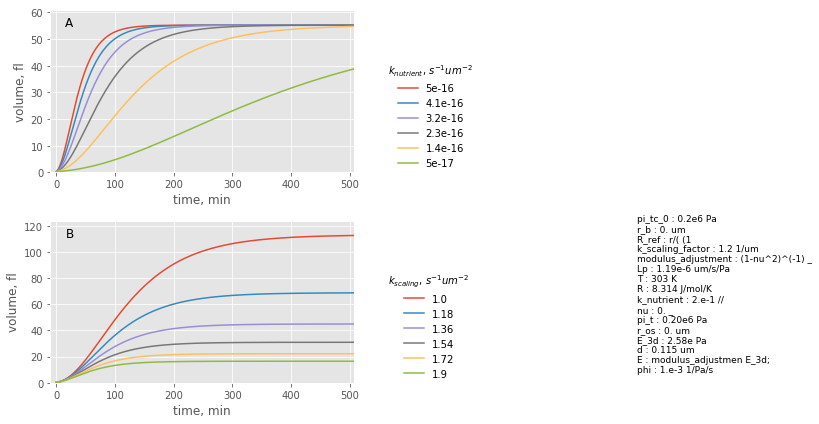

In [22]:
modeltxt='volume_reference_radius.txt'
model=te.loadAntimonyModel(modeltxt)

model_species=['time','V_tot_fl', '[c_e]', '[c_i]','pi_i','pi_e', 'R_ref', 'r','r_os', 'r_b', 'pi_t', 'V_ref']
end_time = 30400
steps = 1000

#sensitivity 
para_2change_dic={'k_nutrient': np.linspace(5e-16,5e-17, num=6),
                  'k_scaling_factor': np.linspace(1,1.9, num=6)}

#model
observables = ['time','V_tot_fl','r']#model_species
number_of_observables = len(observables)-1
number_of_paras = len(para_2change_dic.keys())
var=observables[1]

# Plot
subplots=len(para_2change_dic)
fig1, ax=plt.subplots(subplots,2)
fig1.set_size_inches(10,6)

para_name = para_2change_dic.keys()[0]


for k, para_name in enumerate(para_2change_dic.keys()):
    
    model.resetToOrigin()
    if subplots == 1:
        ax_k=ax
        
    else:
        ax_k=ax[k]
        
    ax_k[-1] .axis('off') 
    values=para_2change_dic[para_name]
    
    plot_sens(model,
              ax_k[0],
              para_name,
              values,
              end_time=end_time,
              steps=steps,
              scale='min')
    add_plot_label(k, ax_k[0])
 
print_model_parameters(modeltxt, ax_k[-1], fontsize=9)
plt.savefig('plots/parameter_sensitivity.png',dpi=300)



<open file 'volume_reference_radius.txt', mode 'rb' at 0x7f387d0086f0>


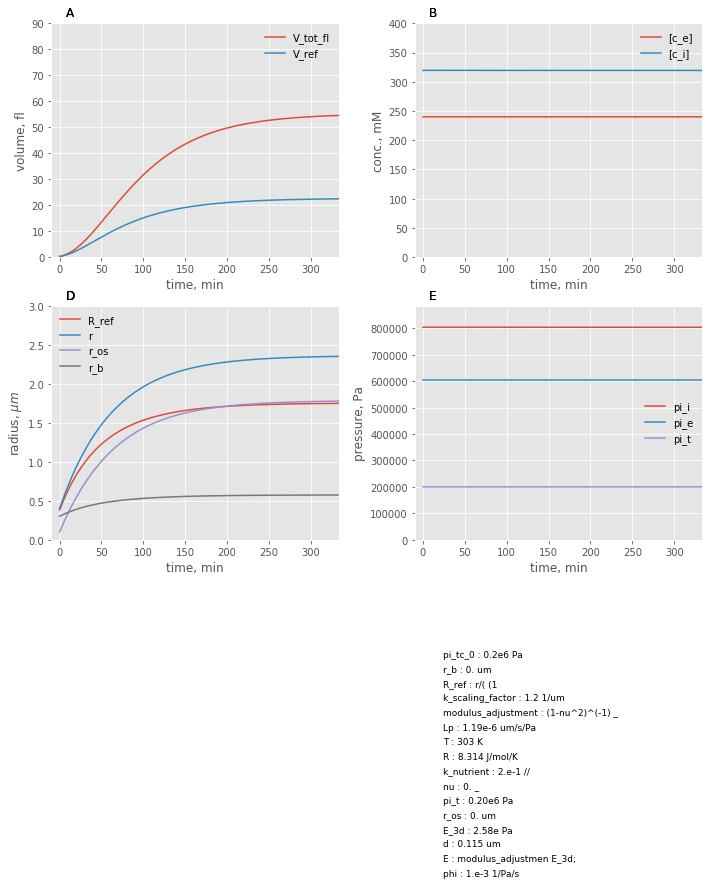

In [26]:
modeltxt='volume_reference_radius.txt'
model=te.loadAntimonyModel(modeltxt)
model_species=['time','V_tot_fl', '[c_e]', '[c_i]','pi_i','pi_e', 'R_ref', 'r','r_os', 'r_b', 'pi_t', 'V_ref']
end_time = 20000
sim=model.simulate(1, end_time, 2000, selections = model_species)

#tom


variables = sim.colnames
number_of_variables = len(variables)



paras_dic = {}
paras_dic = get_paras_dic(modeltxt)
time, xlim  = time_in_s_or_min(sim['time'], scale='min')


# Plot
fig1, ax = plt.subplots(2,2)#, sharex=True)
fig1.set_size_inches(10,8)

max_y = 0
pos=(0.05,1.03)

for var in variables:
    
    
    if var == 'time':
        continue
    if var.startswith('V'):
        plot_details(sim, time, var, ax[0][0], title=' ', max_y=90,  scale='min', xlim=xlim)
        add_plot_label(0, ax=ax[0][0], pos=pos)
    elif var.startswith('[c'):
        plot_details(sim, time, var, ax[0][1], title=' ',max_y=400, scale='min', xlim=xlim, ylabel='conc., mM')
        add_plot_label(1, ax=ax[0][1], pos=pos)    
#     elif var.startswith('r_'):
#         plot_details(sim, time, var,   max_y=3, ax=ax[1][0], scale='min', xlim=xlim, ylabel=r'radius, ${\mu} m$')
#         add_plot_label(2, ax=ax[1][0],pos=pos)
    elif var in ['r', 'R_ref', 'r_os', 'r_b']:
        plot_details(sim, time, var,  ax[1][0], title=' ',max_y=3, scale='min', xlim=xlim, ylabel=r'radius, ${\mu} m$')
        add_plot_label(3, ax=ax[1][0], pos=pos)
    elif var.startswith('p'): 
        max_y = plot_details(sim, time, var, ax[1][1], title=' ',max_y=max_y, scale='min', xlim=xlim, ylabel=r'pressure, Pa')
        add_plot_label(4, ax=ax[1][1], pos=pos)
    else:
        pass
        


#ax[-1][-1].axis('off')

for pos,key in enumerate(paras_dic):
    ax[-1][-1].text(0.1, 1./len(paras_dic)*(pos+1)-1.5, key  + ' : ' + paras_dic[key], fontsize=9, transform=ax[-1][-1].transAxes)
   
    plt.tight_layout()

plt.savefig('plots/simulation__refradius_osmo.png',dpi=300)
